# Risk Management I: Dynamic Hedging

Whilst some buy-side institutions wish to trade options as a form of insurance, most investors use them to speculate on volatility. The latter do not wish to take a directional view on the market. Sell-side market-makers faciliate this client flow and aim to make money on the bid-ask spread regardless of the way in which the market is moving. Akin to volatility traders, they want their option portfolios to be insensitive to movements in the underlying. This can be achieved by delta-hedging: the P&L of a continuously hedged position is proportional to the difference between realised and implied volatiltiy.

Delta, $\Delta$, measures the sensitivity of the option price ($V$) to changes in the underlying:

$\Delta(S;t) = \frac{\partial V}{\partial S}$

For a European call option the analytical result is:

$\Delta(S;t) = \Phi(d_1)$  where $d_1 = \frac{\ln(S/K)+(r+\sigma^2/2)T}{\sigma\sqrt{T}}$ and and $\Phi(x)$ is the cumulative Normal distribution function.

In this case, Delta is clearly in $[0,1]$ and, for a given moment in time, can be interpretted as the number of shares that the option instantaneously behaves like. 

The function below computes Delta. For example, an option on an asset with volatility 14% per annum ($\sigma = 0.14$), strike price \$205, time to maturity of six months ($T=0.5$) and a risk-free interest rate of 2% ($r=0.02$) has $\Delta = 0.46$ when the underlying is \$200. This suggests that if one has sold 100 of these options, they should buy 46 of the underlying to hedge their position. Note that they will have to re-hedge when the underlying price changes.

In [3]:
import numpy as np
import scipy.stats as ss

def d1(S, K, r, sigma, T):
    return ( np.log(S/K) + (r + sigma**2/2)*T ) / (sigma * np.sqrt(T))

def DeltaExact(S, K, r, sigma, T):
    return ss.norm.cdf(d1(S, K, r, sigma, T))


In [2]:
DeltaExact(200, 205, 0.02, 0.14, 0.5)

0.46060076541543943

Of course, if one were pricing a more complex option then Delta would have to be numerically approximated as an analytic solution might not be available. This could be achieved in conjunction with any of the numerical procedures investigated previously. For speed of calculation, I will use a Binomial Tree.

Recall that $c(i,j)$ is the price of a call option at time $i\Delta t$ ($0\leq i\leq N$) with an underlying price of $S_0 u^j d^{i-j}$ ($0\leq j \leq i$). Thus Delta can be approximated after the first branch in the tree at $t=\delta t \approx 0$, $S = S_0$ as:

$ [\frac{\partial c}{\partial S}] \approx \frac{c(1,1)-c(1,0)}{S_0u - S_0d}$

Note that this results in a value that is the same as the analytical solution to four decimal places.

In [4]:
import numpy as np
import math

def CRRCall(S0, K, r, sigma, T, N):
    
    delta_t = T/N;
        
    u = np.exp(sigma * np.sqrt(delta_t))
    d = np.exp(-sigma * np.sqrt(delta_t))
    p = (np.exp(r*delta_t) - d)/(u - d)
    
    c = [[0 for i in range(N+1)] for j in range(N+1)]
    
    for j in range(N+1):
        c[N][j] = max( S0*math.pow(u,j)*math.pow(d,N-j) - K, 0)
        
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            c[i][j] = np.exp(-r * delta_t)*( p*c[i+1][j+1] + (1-p)*c[i+1][j] )
        
    return c, u, d

def Delta(S, K, r, sigma, t):
    
    c, u, d = CRRCall(S, K, r, sigma, t, 1000)
    
    return ( c[1][1] - c[1][0] ) / (S*u - S*d)

In [19]:
Delta(200, 205, 0.02, 0.14, 0.5)

0.46055115993509788

Suppose that a market-maker has written the same option described previously on 100,000 underlying assets. In order to remain delta-neutral (insensitive to movements in the underlying) they must hedge their position as often as possible. The hedge depends on the current asset price.

The function GBMPath below simulates a trajectory of the underlying modelled using Geometric Brownian Motion. The discretised SDE is:

$\Delta S = \mu S \Delta t + \sigma S \Delta W$,

where $W$ is a Wiener process and hence $\Delta W \sim N(0,\Delta t)$.

The function DynamicHedgeSimulation produces a ledger for the market-maker using this simulated path, where $n$ is the number of hedges they wish to make during the lifetime of the option. At each time step the underlying price changes and so Delta must be updated. The previous Delta function can be reused, viewing the derivative as a new option with new $S_0$ and a time to maturity of $T-\Delta t$. The final value of Delta is then either 1 (if the option closes in the money) or 0 (if the option closes out of the money).

This value of Delta tells them how many assets they should be holding to hedge the option position - as indicated in the Assets Purchased column. These values are positive if Delta increased and so more assets had to be purchased or negative is Delta decreased and some assets could be sold. The cost from the purchase or sale of these assets is recorded in the next column.

At the end of each time period the continuously compounded interest that is incurred in borrowing to purchase these assets at the risk-free rate is recorded in the final column. This interest is added onto the cost of the next time period recorded in the penultimate Cumulative Cost column.

If the option closes out of the money then the final value in the Cumulative Cost column is the total cost of hedging the option. If the option closes in the money then it will be exercised by the purchaser and so one must account for the $100000K$ that the hedger will receive in exchange for the underlying assets that have been accumulated.

In [5]:
import pandas as pd
import numpy as np

def GBMPath(S0, K, sigma, T, mu, delta_t, n):
    
    # n samples from Normal distribution with mean = 0 and variance = delta_t
    Weiner = np.random.normal(0, math.sqrt(delta_t), n)
        
    path = np.zeros(n+1)
    
    path[0] = S0
    
    for i in range(1, n+1):
        path[i] = path[i-1] + path[i-1]*(mu*delta_t + sigma*Weiner[i-1])
    
    return path

def Deltas(time_col, path, K, r, sigma, T):
    
    deltas = np.zeros(len(path))
    
    for i in range(len(path)-1):
            
        c, u, d = CRRCall(path[i], K, r, sigma, T-time_col[i] , 1000)
        
        deltas[i] = ( c[1][1] - c[1][0] ) / (path[i]*u - path[i]*d)
        
    if path[-1] >= K:
        deltas[-1] = 1
    else:
        deltas[-1] = 0
    
    return deltas

def Assets(deltas):
    
    assets = np.zeros(len(deltas))
    
    assets[0] = deltas[0]*100000
    
    for i in range(1, len(deltas)):
        
        assets[i] = (deltas[i] - deltas[i-1])*100000

    return assets    

def Costs(path, assets):
    
    costs = np.zeros(len(path))
    
    for i in range(len(path)):
        
        costs[i] = assets[i]*path[i]/1000

    return costs  

def FinalCosts(costs, delta_t, r):
    
    cumulative = np.zeros(len(costs))
    interest = np.zeros(len(costs))
    
    cumulative[0] = costs[0]
    interest[0] = cumulative[0]*np.exp(r * delta_t) - cumulative[0]
    
    for i in range(1, len(costs)):
        
        cumulative[i] = cumulative[i-1] + interest[i-1] + costs[i] 
        interest[i] = cumulative[i]*np.exp(r * delta_t) - cumulative[i]

    interest[-1] = 0
    
    return [cumulative, interest]

def DynamicHedgeSimulation(S0, K, r, sigma, T, mu, n):
    
    delta_t = T/n
    
    cols = ["Asset Price", "Delta", "Assets Purchased", "Cost of Purchase ($1000)", "Cum. Cost inc Interest ($1000)", "Interest ($1000)"]
        
    time_col = pd.Series([i*delta_t for i in range(n + 1)])
    
    ledger = pd.DataFrame( np.zeros((len(time_col), 6)) , columns = cols)
    
    ledger.insert(0, "Time", time_col)
    
    path = GBMPath(S0, K, sigma, T, mu, delta_t, n)
    
    ledger["Asset Price"] = path
    
    deltas = Deltas(time_col, path, K, r, sigma, T)
    
    ledger["Delta"] = deltas
    
    assets = Assets(deltas)
    
    ledger["Assets Purchased"] = assets
    
    costs = Costs(path, assets)
    
    ledger["Cost of Purchase ($1000)"] = costs
    
    [cumulative, interest] = FinalCosts(costs, delta_t, r)
    
    ledger["Cum. Cost inc Interest ($1000)"] = cumulative
    
    ledger["Interest ($1000)"] = interest
        
    print(ledger.round(3))
    
    print("\n")
    
    if path[-1] >= K:
        hedge_cost = (cumulative[-1]*1000 - 100000*K)
        print("Option closes in the money and is exercised.\n")
        print("Hedging cost: ${:.2f}\n".format(hedge_cost))
        
    else:
        hedge_cost = cumulative[-1]*1000
        print("Option closes out of the money and is not exercised.\n")
        print("Hedging cost: ${:.2f}\n".format(hedge_cost))
    
    discounted_cost = hedge_cost*np.exp(-r * T)
    print("Discounted cost: ${:.2f}".format(discounted_cost))


In [21]:
DynamicHedgeSimulation(200, 205, 0.02, 0.14, 0.5, 0.04, 26)

     Time  Asset Price  Delta  Assets Purchased  Cost of Purchase ($1000)  \
0   0.000      200.000  0.461         46055.116                  9211.023   
1   0.019      193.231  0.322        -13835.165                 -2673.376   
2   0.038      195.792  0.367          4524.110                   885.784   
3   0.058      198.265  0.414          4655.214                   922.965   
4   0.077      200.001  0.447          3322.542                   664.513   
5   0.096      194.376  0.322        -12550.936                 -2439.596   
6   0.115      195.963  0.349          2753.781                   539.639   
7   0.135      193.810  0.296         -5279.993                 -1023.316   
8   0.154      191.364  0.239         -5778.686                 -1105.830   
9   0.173      195.279  0.314          7510.378                  1466.621   
10  0.192      192.726  0.249         -6456.537                 -1244.341   
11  0.212      185.509  0.112        -13704.705                 -2542.340   

The theoretical cost of this option, as determined by the Black-Scholes formula, is \$656112. Note that the cost of hedging, once discounted to the beginning of the period, is close to this value. Nevertheless there is still quite a lot of variation as we are only re-hedging once a week. As the frequency of hedging increases, as $n$ increases, these two values converge. This is because the hedger synthetically creates a long position in the option, to offset the short position that arose in writing the option. The function PlotHedgingCosts() below illustrates this converging process, using an adapted DynamicHedgeSimulation() function that employs DeltaExact() for speed. The dashed line shows the Black-Scholes price.

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def Deltas(time_col, path, K, r, sigma, T):
    
    deltas = np.zeros(len(path))
    
    for i in range(len(path)-1):
                    
        deltas[i] = DeltaExact(path[i], K, r, sigma, T-time_col[i])
        
    if path[-1] >= K:
        deltas[-1] = 1
    else:
        deltas[-1] = 0
    
    return deltas

def DynamicHedgeSimulation(S0, K, r, sigma, T, mu, n):
    
    delta_t = T/n
    
    cols = ["Asset Price", "Delta", "Assets Purchased", "Cost of Purchase ($1000)", "Cum. Cost inc Interest ($1000)", "Interest ($1000)"]
        
    time_col = pd.Series([i*delta_t for i in range(n + 1)])
    
    ledger = pd.DataFrame( np.zeros((len(time_col), 6)) , columns = cols)
    
    ledger.insert(0, "Time", time_col)
    
    path = GBMPath(S0, K, sigma, T, mu, delta_t, n)
    
    ledger["Asset Price"] = path
    
    deltas = Deltas(time_col, path, K, r, sigma, T)
    
    ledger["Delta"] = deltas
    
    assets = Assets(deltas)
    
    ledger["Assets Purchased"] = assets
    
    costs = Costs(path, assets)
    
    ledger["Cost of Purchase ($1000)"] = costs
    
    [cumulative, interest] = FinalCosts(costs, delta_t, r)
    
    ledger["Cum. Cost inc Interest ($1000)"] = cumulative
    
    ledger["Interest ($1000)"] = interest
    
    if path[-1] >= K:
        hedge_cost = (cumulative[-1]*1000 - 100000*K)
        
    else:
        hedge_cost = cumulative[-1]*1000
    
    discounted_cost = hedge_cost*np.exp(-r * T)
    
    return discounted_cost

def PlotHedgingCosts():
    
    num_hedges = [100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 25000, 50000, 75000, 100000]
    hedging_costs = []
        
    for n in num_hedges:
        print("Computing hedging price for {} rebalances".format(int(n)))
        hedging_costs.append(DynamicHedgeSimulation(200, 205, 0.02, 0.14, 0.5, 0.04, int(n)))
            
    plt.style.use(['bmh'])
    fig, ax = plt.subplots(1)
    fig.suptitle("Discounted hedging costs as a function of number of rebalances", fontsize=16)
    ax.set_xlabel('Number of rebalances')
    ax.set_ylabel('Discounted Hedging Cost ($)')
    plt.hlines(656112, 0, 100000, linestyles = 'dashed')
    plt.plot(num_hedges, hedging_costs, '-o')
    ax.set_xlim([0,100000])
    plt.show()

Computing hedging price for 100 rebalances
Computing hedging price for 500 rebalances
Computing hedging price for 1000 rebalances
Computing hedging price for 2000 rebalances
Computing hedging price for 3000 rebalances
Computing hedging price for 4000 rebalances
Computing hedging price for 5000 rebalances
Computing hedging price for 6000 rebalances
Computing hedging price for 7000 rebalances
Computing hedging price for 8000 rebalances
Computing hedging price for 9000 rebalances
Computing hedging price for 10000 rebalances
Computing hedging price for 25000 rebalances
Computing hedging price for 50000 rebalances
Computing hedging price for 75000 rebalances
Computing hedging price for 100000 rebalances


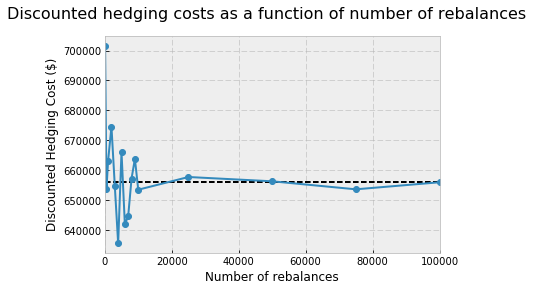

In [7]:
PlotHedgingCosts()

#### Black-Scholes Analysis

It is no coincidence that these prices converge, as the hedger scheme is really just mimicking the Black-Scholes option pricing analysis.

That is, assume the underlying asset follows GBM:

$d S = \mu S d t + \sigma S d W$,

and that the price of the option, $V$, is some function of $S$ and $t$. Ito's Lemma then gives us that:

$dV = (\frac{\partial V}{\partial S}\mu S + \frac{\partial V}{\partial t} + \frac{1}{2}\frac{\partial^2 V}{\partial S^2}\sigma^2S^2)dt + \frac{\partial V}{\partial S}\sigma S dW$

The insight of Black & Scholes was then that one could construct a riskless portfolio, $\Pi$, that is short one option contract and long $\frac{\partial V}{\partial S}$ ( or $\Delta$ ) shares. Thus the value of this portfolio at any given time is:

$\Pi = -V + \frac{\partial V}{\partial S}S$

The value of this portfolio varies according to:

$d \Pi = -dV + \frac{\partial V}{\partial S}dS$

By substituting in $dS$ (from GBM) and $dV$ (from Ito) one obtains:

$d \Pi = (-\frac{\partial V}{\partial t} - \frac{1}{2}\frac{\partial^2 V}{\partial S^2}\sigma^2S^2)dt$

Note that the variable Wiener dependence has been eliminated, and so this portfolio changes by a fixed, deterministic amount during time $dt$. Under the assumption that no arbitrage opportunities exist in this market, the portfolio must earn the risk-free rate over this time period. This is called a *replicating* portfolio as it replicates the cash-flows of another asset. In this case it replicates a risk-free bond - an asset that we know how to price. This replication is called *dynamic* since the portfolio has to be continually rebalanced to replicate the bond. 

$d\Pi = r\Pi dt$

Substituting values in for $d\Pi$ and $\Pi$ one obtains the Black-Scholes PDE:

$-\frac{\partial V}{\partial t} - \frac{1}{2}\frac{\partial^2 V}{\partial S^2}\sigma^2S^2 = r(-V + \frac{\partial V}{\partial S}S)$

Thus you can see that the instantaneous equivalence between an option contract and $\Delta$ shares is baked into the derivation of the Black-Scholes price. 

#### Hedging in Practice

The Black-Scholes analysis above shows how one can create a portfolio consisting of an option and shares to replicate a bond. Alternatively one could create a portfolio consisting of shares and a bond to replicate an option. This dynamic replication argument is key to the Black-Scholes option pricing formula.

However, in practice one would have to rebalance the portfolio very frequently to maintain this replication. We did not account for any transaction costs and assumed that we would always be able to buy or sell the shares that we needed - we assumed the market was *complete*. We also assumed that no arbitrage opportunities exist. Whilst this might nearly be true for some liquid equity markets, it will almost certainly not be true for an illiquid commodity market. Nevertheless, Black-Scholes pricing formulae are still used here.

We have arrived upon the Hakkanson Paradox: If markets are complete and arbitrage free then options can be replicated and hence they are not needed. Else, if markets are incomplete then we cannot replicate options, thus they may be needed, but how on earth do we price them? Some theoretical work in this field by Taleb and Derman may have solved this riddle: markets are incomplete but one can still price options. See [[1](http://www.risknet.eu/fileadmin/eLibrary/Taleb-Illusions-dynamic-replication-2005.pdf)] and [[2](https://arxiv.org/pdf/1405.2609.pdf)].

In practice, after charging clients for the cost of an option, market-makers offer to do an initial Delta exchange with them. This satisfies most clients who also wish to be Delta neutral. If the client declines then they are charged for the cost of an initial Delta hedge. After this, both parties are responsible for their own risk management. They will probably employ a hedging scheme similar to that built above.

Maintaining delta-neutrality on an individual option would be prohibitively expensive as many transaction costs would be incurred. However, there are economies of scale to exploit. It is much more feasible to hedge a portfolio of several hundred options all based on the same underlying. In addition, one will hedge only as frequently as is needed in order to remain within risk limits.

#### Profit & Loss

Note that delta-hedging is just one hedging strategy and others exist. For a given number of rebalancings (fixed $n$) the overall PnL ($\epsilon$) of a hedging scheme (the difference between the hedging cost and the premium charged) can be calculated. This PnL depends on the exact path taken by the underlying and so one should really treat it as a random variable with a distribution for a given value of $n$.

The mean of this PnL should be zero for all values of $n$ and any sensible strategy [ $E(\epsilon)=0$ ]. However the variance will depend on $n$ and the specific hedging strategy employed. It can be shown that under the BS model and an infinite number of rebalances, delta-hedging is the most optimal strategy in that it minimises this variance. However, for a finite value of $n$ other strategies are optimal though they can be difficult to compute in real-time - see the summary below for a review of this field.

It can be shown that the standard deviation of this PnL under the BS model using delta-hedging decays like $n^{-\frac{1}{2}}$ as $n\rightarrow\infty$ - see [3](http://www.emanuelderman.com/writing/entry/when-you-cannot-hedge-continuously-the-corrections-of-black-scholes).

For a given value of $n$ the function PlotPnLSD() below computes the standard deviation of the PnL (estimated from 100 trials) divided by the BS premium price. It then plots this on a log-log scale as a function of $n$. A linear least-squares regression line is estimated and plotted on the same axes. The gradient of this line is around -0.5 and so verifies the above result.

It can also be shown that if in addition to delta-hedging, one also gamma-hedges, then the standard deviation of PnL decays even quicker, like $n^{-1}$.

In [116]:
def PlotPnLSD():
    
    num_hedges = [100, 500, 1000, 2000, 3000, 4000, 5000, 6000]
    pnl_sd = []
        
    for n in num_hedges:
        print("Computing PnL standard deviation for {} rebalances".format(int(n)))
        pnl = []
        for x in range(100):
            pnl.append(656112 - DynamicHedgeSimulation(200, 205, 0.02, 0.14, 0.5, 0.04, int(n)))
            
        pnl_sd.append(np.std(pnl, ddof=1)/656112)
            
    plt.style.use(['bmh'])
    fig, ax = plt.subplots(1)
    fig.suptitle("A log-log graph showing standard deviation of PnL as a function of number of rebalances", fontsize=16)
    ax.set_xlabel('Number of rebalances')
    ax.set_ylabel('Standard Deviation of PnL ($)')
    plt.plot(np.log(num_hedges), np.log(pnl_sd), 'o')
    
    [m , c] = np.polyfit(np.log(num_hedges), np.log(pnl_sd), 1)
    plt.plot(np.log(num_hedges), m*np.log(num_hedges) + c, '-')
    plt.show()
    
    print("Regression line has a gradient of {}".format(m))

Computing PnL standard deviation for 100 rebalances
Computing PnL standard deviation for 500 rebalances
Computing PnL standard deviation for 1000 rebalances
Computing PnL standard deviation for 2000 rebalances
Computing PnL standard deviation for 3000 rebalances
Computing PnL standard deviation for 4000 rebalances
Computing PnL standard deviation for 5000 rebalances
Computing PnL standard deviation for 6000 rebalances


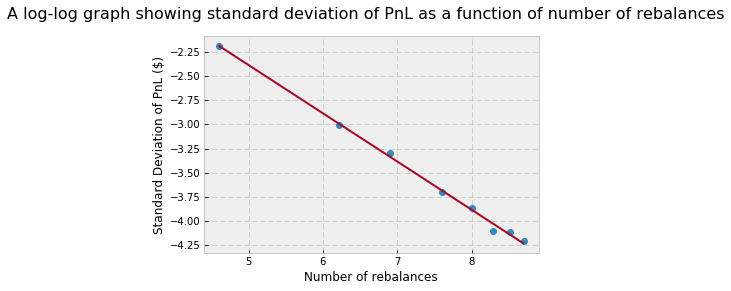

Regression line has a gradient of -0.4979726974721473


In [30]:
PlotPnLSD()

The PnL of a hedging strategy should be monitored throughout its duration, rather than simply noted at the end, so that risks can be monitored. Consider the same option writing scenario as before. The market-maker's total portfolio, at any given time, can then be considered as:

Portfolio = - Option + Assets + Cash

The market-maker has sold the option and so is always down its current value. Cash begins with the BS premium that the buyer pays and is used to buy assets according to the hedging strategy. During any given time interval interest may be gained or lost depending on the sign of the current cash balance.

Thus, at $t=0$ the portfolio's value is:

$\Pi_{S_0, 0} = -V(S_0, 0) + \frac{\partial V}{\partial S}_{S_0,0}S_0 + \big(V(S_0, 0) - \frac{\partial V}{\partial S}_{S_0,0}S_0 \big) = 0$

At $t=\Delta t$, when $S = S_0 + \Delta S$, its value is:

$\Pi_{S_0+\Delta S, \Delta t} = -V(S_0 + \Delta S, \Delta t) + \frac{\partial V}{\partial S}_{S_0 + \Delta S,\Delta t}(S_0 + \Delta S) + (\text{previous cash balance} - \text{cost of buying extra assets})$

$\;\;\;\;\;\;\;\;\;\;\;\;\; = -V(S_0 + \Delta S, \Delta t) + \frac{\partial V}{\partial S}_{S_0 + \Delta S,\Delta t}(S_0 + \Delta S) + \big(V(S_0, 0) - \frac{\partial V}{\partial S}_{S_0,0}S_0 - \big(\frac{\partial V}{\partial S}_{S_0 + \Delta S,\Delta t} - \frac{\partial V}{\partial S}_{S_0,0}\big)(S_0 + \Delta S)\big)$

$\;\;\;\;\;\;\;\;\;\;\;\;\; = -V(S_0 + \Delta S, \Delta t) + V(S_0, 0) + \frac{\partial V}{\partial S}_{S_0,0}S_0$

The PnL from one time interval to the next is the change in value of this portfolio. For example, buying assets according to a delta-hedging strategy, the PnL from $t=0$ to $t=\Delta t$ is:

$\text{PnL}_{S_0 + \Delta S, \Delta t} = \Pi_{S_0 + \Delta S, \Delta t} - \Pi_{S_0, 0} = -V(S_0 + \Delta S, \Delta t) + V(S_0, 0) + \frac{\partial V}{\partial S}_{S_0,0}S_0$

A Taylor expansion can now be used if $\Delta S, \Delta t \ll 1$. Noting that $\Delta t \ll \Delta S$, we expand to first-order in $\Delta t$ and second-order in $\Delta S$:

$V(S_0 + \Delta S, \Delta t) \approx V(S_0,0) + \frac{\partial V}{\partial S}_{S_0,0}\Delta S + \frac{\partial V}{\partial t}_{S_0,0}\Delta t + \frac{1}{2}\frac{\partial^2 V}{\partial S^2}_{S_0,0}(\Delta S)^2$

This gives:

$\text{PnL}_{S_0 + \Delta S, \Delta t} \approx -\Theta_{S_0,0}\Delta t - \frac{1}{2}\Gamma_{S_0,0}(\Delta S)^2$

where $\Theta = \frac{\partial V}{\partial t}$ is the measure of the options sensitivity to time and $\Gamma = \frac{\partial^2 V}{\partial S^2}$ is the options second-order sensitivity to asset movements.

The function DynamicPnLSimulation() below produces a ledger similar to before, but this time computes PnL throughout the lifetime of the option and compares it to the estimate above. The exact BS formulae for pricing, delta, theta and gamma are used for speed. For a call option these are:

$\Theta = -\frac{S_0\sigma}{2\sqrt{2\pi T}}e^{-\frac{1}{2}d^2_1} - rKe^{-rT}N(d_2)$

$\Gamma = \frac{1}{S_0 \sigma \sqrt{2\pi T}}e^{-\frac{1}{2}d^2_1}$

In [1]:
import math
import scipy.stats as ss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def GBMPath(S0, K, sigma, T, mu, delta_t, n):
    
    # n samples from Normal distribution with mean = 0 and variance = delta_t
    Weiner = np.random.normal(0, math.sqrt(delta_t), n)
        
    path = np.zeros(n+1)
    
    path[0] = S0
    
    for i in range(1, n+1):
        path[i] = path[i-1] + path[i-1]*(mu*delta_t + sigma*Weiner[i-1])
    
    return path

def d1(S0, K, r, sigma, T):
    return ( np.log(S0/K) + (r + sigma**2/2)*T ) / (sigma * np.sqrt(T))

def d2(S0, K, r, sigma, T):
    return d1(S0, K, r, sigma, T) - sigma*np.sqrt(T)

def BlackScholesExactCall(S0, K, r, sigma, T):
    price = S0*ss.norm.cdf(d1(S0, K, r, sigma, T)) - K*np.exp(-r*T)*ss.norm.cdf(d2(S0, K, r, sigma, T))    
    delta = ss.norm.cdf(d1(S0, K, r, sigma, T))
    theta = -S0*sigma*np.exp(-0.5*d1(S0, K, r, sigma, T)**2)/(2*np.sqrt(2*math.pi*T)) - r*K*np.exp(-r*T)*ss.norm.cdf(d2(S0, K, r, sigma, T))
    gamma = np.exp(-0.5*d1(S0, K, r, sigma, T)**2)/(S0*sigma*np.sqrt(2*math.pi*T))
    
    return [price, delta, theta, gamma]

def BlackScholes(time_col, path, K, r, sigma, T):
    
    options = np.zeros(len(path))
    deltas = np.zeros(len(path))
    thetas = np.zeros(len(path))
    gammas = np.zeros(len(path))
    
    for i in range(len(path)-1):
        [options[i], deltas[i], thetas[i], gammas[i]] = BlackScholesExactCall(path[i], K, r, sigma, T-time_col[i])
        options[i] = -100*options[i]
        
    if path[-1] >= K:
        options[-1] = -100*(path[-1] - K)
        deltas[-1] = 1
        
    else:
        options[-1] = 0
        deltas[-1] = 0
                
    return [options, deltas, thetas, gammas]

def Assets(path, deltas):
    
    assets = np.zeros(len(deltas))
        
    for i in range(len(deltas)):
        
        assets[i] = deltas[i]*path[i]*100

    return assets    

def FinalCosts(deltas, options, delta_t, r, path, K):
    
    cash = np.zeros(len(path))
    interest = np.zeros(len(path))
        
    cash[0] = -options[0] - deltas[0]*path[0]*100
    interest[0] = cash[0]*np.exp(r * delta_t) - cash[0]
    
    for i in range(1, len(path)):
        
        sharesToBuy = deltas[i] - deltas[i-1]
        cash[i] = cash[i-1] - sharesToBuy*path[i]*100 + interest[i-1]
        interest[i] = cash[i]*np.exp(r * delta_t) - cash[i]

    interest[-1] = 0
    
    return [cash, interest]    

def DynamicPnLSimulation(S0, K, r, sigma, T, mu, n):
    
    delta_t = T/n
        
    cols = ["Asset Price", "Option ($1000)", "Delta", "Theta", "Gamma", "Asset Balance ($1000)", "Cash Balance inc Interest ($1000)", "Interest ($1000)", "Portfolio ($1000)", "PnL ($1000)", "PnL Predict ($1000)"]
        
    time_col = pd.Series([i*delta_t for i in range(n + 1)])
    
    ledger = pd.DataFrame( np.zeros((len(time_col), 11)) , columns = cols)
    
    ledger.insert(0, "Time", time_col)
    
    path = GBMPath(S0, K, sigma, T, mu, delta_t, n)
    
    ledger["Asset Price"] = path
    
    [options, deltas, thetas, gammas] = BlackScholes(time_col, path, K, r, sigma, T)
        
    ledger["Option ($1000)"] = options
        
    ledger["Delta"] = deltas
    
    ledger["Theta"] = thetas
    
    ledger["Gamma"] = gammas
    
    assets = Assets(path, deltas)
    
    ledger["Asset Balance ($1000)"] = assets
    
    [cash, interest] = FinalCosts(deltas, options, delta_t, r, path, K)
    
    ledger["Cash Balance inc Interest ($1000)"] = cash
        
    ledger["Interest ($1000)"] = interest
            
    ledger["Portfolio ($1000)"] = options + assets + cash
        
    ledger["PnL ($1000)"] = ledger['Portfolio ($1000)'] - ledger['Portfolio ($1000)'].shift(1)
        
    delta_S = ledger["Asset Price"] - ledger["Asset Price"].shift(1)
    
    ledger["PnL Predict ($1000)"] = - 100*(ledger["Theta"].shift(1)*delta_t + 0.5*ledger["Gamma"].shift(1)*np.square(delta_S))
    
    pd.set_option('display.width', 80)
    
    print(ledger.round(3))
    
    print("\n")

In [3]:
DynamicPnLSimulation(200, 205, 0.02, 0.14, 0.5, 0.04, 26)

     Time  Asset Price  Option ($1000)  Delta   Theta  Gamma  \
0   0.000      200.000        -656.112  0.461  -9.571  0.020   
1   0.019      196.557        -492.137  0.388  -9.025  0.020   
2   0.038      195.662        -441.206  0.365  -8.916  0.020   
3   0.058      190.469        -263.945  0.258  -7.415  0.018   
4   0.077      190.096        -240.391  0.245  -7.314  0.018   
5   0.096      186.326        -148.982  0.174  -5.891  0.015   
6   0.115      187.063        -150.392  0.178  -6.140  0.016   
7   0.135      184.092         -94.737  0.127  -4.875  0.013   
8   0.154      189.082        -163.044  0.196  -6.930  0.018   
9   0.173      190.331        -174.543  0.210  -7.484  0.019   
10  0.192      194.459        -260.416  0.287  -9.426  0.023   
11  0.212      196.510        -304.180  0.327 -10.465  0.024   
12  0.231      195.238        -245.357  0.287 -10.049  0.024   
13  0.250      194.866        -215.754  0.268  -9.995  0.024   
14  0.269      195.737        -219.757  

For the most part the PnL predictions well match the actual values. As the number of re-hedges increases, $\Delta t$ and hence $\Delta S$ will decrease, thus increasing the accuracy of our Taylor approximation. The function PlotPnLError() below calculates the mean absolute error between the PnL and its prediction across the lifetime of an option for a given value of $n$. It then plots these mean errors as a function of $n$. As expected, as $n$ increases the errors decrease to zero.

In [2]:
def DynamicPnLSimulation(S0, K, r, sigma, T, mu, n):
    
    delta_t = T/n
        
    cols = ["Asset Price", "Option ($1000)", "Delta", "Theta", "Gamma", "Asset Balance ($1000)", "Cash Balance inc Interest ($1000)", "Interest ($1000)", "Portfolio ($1000)", "PnL ($1000)", "PnL Predict ($1000)"]
        
    time_col = pd.Series([i*delta_t for i in range(n + 1)])
    
    ledger = pd.DataFrame( np.zeros((len(time_col), 11)) , columns = cols)
    
    ledger.insert(0, "Time", time_col)
    
    path = GBMPath(S0, K, sigma, T, mu, delta_t, n)
    
    ledger["Asset Price"] = path
    
    [options, deltas, thetas, gammas] = BlackScholes(time_col, path, K, r, sigma, T)
        
    ledger["Option ($1000)"] = options
        
    ledger["Delta"] = deltas
    
    ledger["Theta"] = thetas
    
    ledger["Gamma"] = gammas
    
    assets = Assets(path, deltas)
    
    ledger["Asset Balance ($1000)"] = assets
    
    [cash, interest] = FinalCosts(deltas, options, delta_t, r, path, K)
    
    ledger["Cash Balance inc Interest ($1000)"] = cash
        
    ledger["Interest ($1000)"] = interest
            
    ledger["Portfolio ($1000)"] = options + assets + cash
        
    ledger["PnL ($1000)"] = ledger['Portfolio ($1000)'] - ledger['Portfolio ($1000)'].shift(1)
        
    delta_S = ledger["Asset Price"] - ledger["Asset Price"].shift(1)
    
    ledger["PnL Predict ($1000)"] = - 100*(ledger["Theta"].shift(1)*delta_t + 0.5*ledger["Gamma"].shift(1)*np.square(delta_S))
    
    return ledger
            
def PlotPnLError():
    
    num_hedges = [100, 500, 1000, 2000, 3000, 4000, 5000, 6000]
    mean_pnl_error = []
        
    for n in num_hedges:
        print("Computing mean PnL error for {} rebalances".format(int(n)))
        ledger = DynamicPnLSimulation(200, 205, 0.02, 0.14, 0.5, 0.04, int(n))
        pnl_error = ledger["PnL ($1000)"] - ledger["PnL Predict ($1000)"]
        pnl_error = np.absolute(pnl_error)
        mean_pnl_error.append(np.mean(pnl_error[1:]))
            
    plt.style.use(['bmh'])
    fig, ax = plt.subplots(1)
    fig.suptitle("A graph showing mean PnL error ($1000) as a function of number of rebalances", fontsize=16)
    ax.set_xlabel('Number of rebalances')
    ax.set_ylabel('Mean PnL Error ($1000)')
    plt.plot(num_hedges, mean_pnl_error, '-o')
    plt.show()

Computing mean PnL error for 100 rebalances
Computing mean PnL error for 500 rebalances
Computing mean PnL error for 1000 rebalances
Computing mean PnL error for 2000 rebalances
Computing mean PnL error for 3000 rebalances
Computing mean PnL error for 4000 rebalances
Computing mean PnL error for 5000 rebalances
Computing mean PnL error for 6000 rebalances


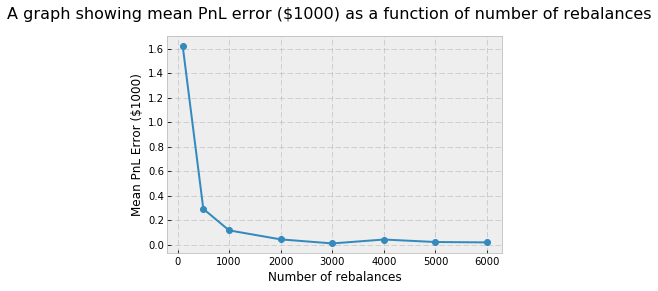

In [4]:
PlotPnLError()

As shown previously for total PnL, under any hedging scheme we expect the mean of real-time PnL to be zero and its standard deviation to decrease as $n$ increases. The function PlotPnLDistributions() below plots histograms of PnL across the lifetime of an option for different values of $n$. Noting the scale on the x-axes, one can see that as $n\rightarrow \infty$, PnL tends to a delta function centred on zero.

In [7]:
def PlotPnLDistributions():
    
    num_hedges = [100, 1000, 10000, 100000]
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (50,50)
    plt.rcParams.update({'font.size': 40})
    plt.style.use(['bmh'])
    i=0
    
    for n in num_hedges:
    
        print("Computing PnL distribution for {} rebalances".format(int(n)))
        ledger = DynamicPnLSimulation(200, 205, 0.02, 0.14, 0.5, 0.04, int(n))
        ax = fig.add_subplot(2, 2, i+1)
        ledger["PnL ($1000)"].hist(ax=ax, bins = 20)
        ax.set_title("PnL ($1000) distribution for n = {}".format(n))
        i += 1
        
    plt.tight_layout()
    plt.show()

Computing PnL distribution for 100 rebalances
Computing PnL distribution for 1000 rebalances
Computing PnL distribution for 10000 rebalances
Computing PnL distribution for 100000 rebalances


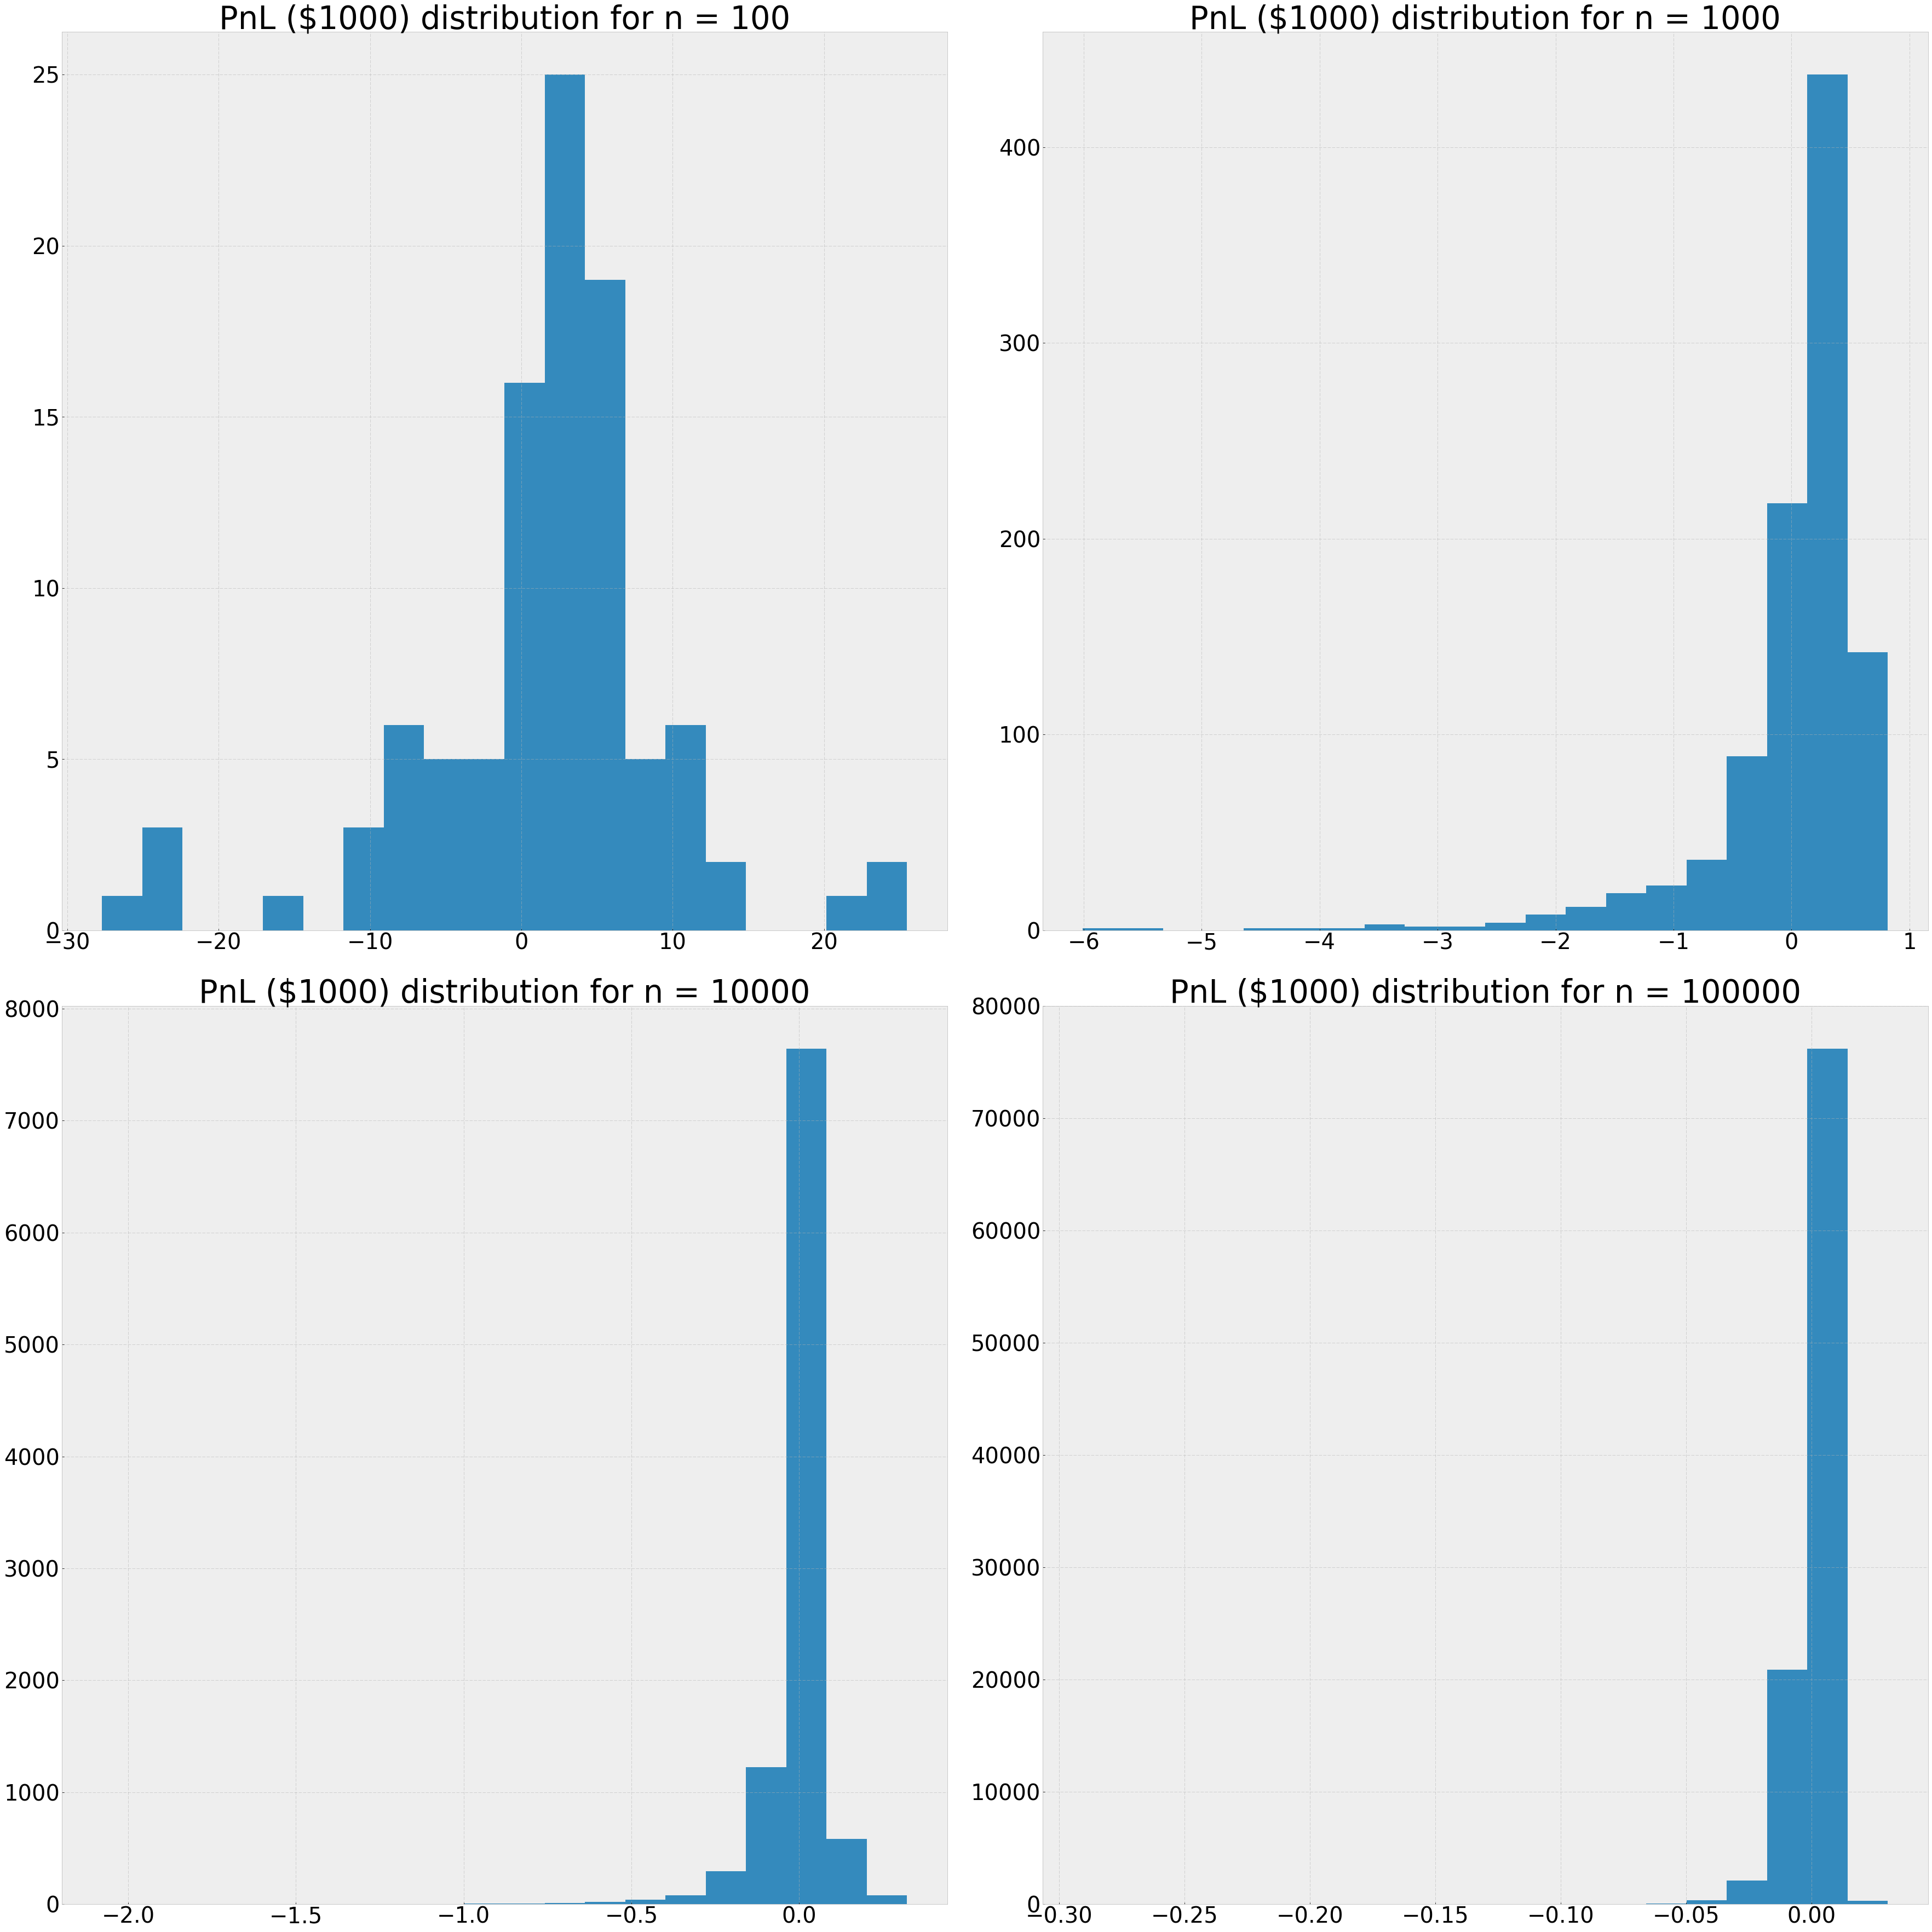

In [8]:
PlotPnLDistributions()

## Summary

After transacting in the market a sell-side trader needs to risk manage their position. For options, this usually begins with a mutually beneficial static delta exchange with the client. After this, each side is responsible for their own risk management. Here the sell-side has the great advantage of scale. They can manage their net exposure: perhaps a portfolio of several hundred options all based on the same underlying.

A hedging strategy tells the trader when and how much of the underlying to purchase to manage their risk. These strategies can be categorised as either time-based (where one rebalances at regular time-intervals without looking separately at the optimality of each re-hedge) or move-based (where a re-hedge is triggered by movements of the underlying). 

We considered the random variable representing the overall PNL: $\epsilon$. Any good hedging strategy is attempting to replicate the option so that $E(\epsilon) = 0$. The optimal hedging strategy can be defined as the one that minimises $\text{Var}(\epsilon)$.

Black-Scholes delta hedging is the simplest time-based strategy. When continuously re-hedging this replicates the option perfectly and $\text{Var}(\epsilon) = 0$. That is, the PnL is zero in every realisation since the cost of the hedge exactly matches the cost of the option. We showed that this is no coincidence and actually at the core of Black-Scholes option pricing.

Clearly in practise one can only re-hedge a finite number of times: $n$. The simplest technique is to apply continuous Black-Scholes hedging at discrete time intervals. This now produces a non-zero $\text{Var}(\epsilon)$ that we showed decreases as $n\rightarrow\infty$. However, this strategy is no longer optimal and one can achieve better results by considering higher order Greeks. In addition, the choice of $n$ is unclear as in reality one must consider transaction costs. As $n$ grows larger $\text{Var}(\epsilon)$ gets smaller but transaction costs mount up, and vice versa. Ultimately the trader's risk preference must be accounted for: are they risk averse (smaller $\text{Var}(\epsilon)$) or risk seeking (smaller transaction costs).

Leland developed a discrete time-based strategy that models transaction costs as proportional to the size of the trade. He essentially revisited the Black-Scholes analysis and deduced a similar PDE but with a modified volatility. One then delta-hedges just as before, but under this pricing framework the modified delta is less sensitive to movements in the underlying (gamma has decreased). This means that for a given change in spot we re-hedge a smaller quantity than under Black-Scholes and hence save on transaction costs. However, this strategy still requires a trader to select an ad-hoc value for $n$ based on their risk-preference.

These two classical models are derived in the risk-neutral world. More recent techniques based on the physical returns distribution are called Optimal Hedging Monte Carlo methods (OHMC - see [[4](https://pdfs.semanticscholar.org/baf9/17d976fff3551b5113b7055402658f18ad8a.pdf)]). These require one to first specify a discrete asset pricing model and calibrate it to historical returns (for example GARCH). Next one uses a Monte Carlo procedure to estimate a hedging strategy that locally minimises the PNL variance at each fixed time-step. This framework fully encompasses transaction costs and allows the user to specify their own asset model.

The simplest move-based strategy is to remain within the Black-Scholes framework and perform a delta-hedge whenever the delta of the portfolio exceeds some fixed tolerance level. The smaller this tolerance is, the more often one will re-hedge and so the smaller $\text{Var}(\epsilon)$ will be at the expense of higher transaction costs. Again this level is rather arbitrary.

A more sophisticated strategy is to maximise the expected utility of the trader's overall PnL. In this technique one insists that the trader is indifferent to selling the option or not (accounting for transaction costs), so that their maximum expected utility does not alter between these two scenarios. Here the arbitrary input shifts to specifying a utility function. By selecting a reasonable utility the problem reduces to a three-dimensional free-boundary problem that can be very computationally intensive to solve. Nevertheless, by assuming that transaction costs are small an asymptotic solution can be deduced that can be interpretted as a move-based strategy with a dynamic tolerance level. This tolerance depends on exactly how the transaction costs are modelled, but intuitively increases with gamma. When gamma is high, delta is sensitive to moves in the underlying and so a small change in spot will mean that one has to re-hedge a large quantity to remain delta neutral. This situation might violate a fixed tolerance level and trigger an unnecessary re-hedging at a significant transaction cost. However, the dynamic tolerance level increases in this scenario.

See [[5](https://editorialexpress.com/cgi-bin/conference/download.cgi?db_name=QMF2005&paper_id=169)] for a full review of discrete hedging under transaction costs.

The latest techniques use non-parametric recurrent neural networks to learn optimal hedging strategies from simulated data (which can include models for transaction costs) by minimising some risk metric (here cVaR) [[5](https://arxiv.org/pdf/1802.03042.pdf)], [[6](https://ipythonquant.wordpress.com/2018/06/05/option-hedging-with-long-short-term-memory-recurrent-neural-networks-part-i/)].